<a href="https://colab.research.google.com/github/ahmadryan/MLTSA_RQudsi/blob/master/HW3_RQudsi/uberprophet_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [3]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

In [5]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [6]:
!pip install fbprophet

In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [9]:
%%time
dfl = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:

    fname = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-%s14.csv' %(mon)
    print( 'Reading data for file %s' %(fname))
    df_temp = pd.read_csv(fname)
    dfl.append(df_temp)
    df_temp = None

df = pd.concat(dfl)

Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
Reading data for file https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv
CPU times: user 2.23 s, sys: 337 ms, total: 2.56 s
Wall time: 20.6 s


In [10]:
df.keys()

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [26]:
%%time
df['time'] = pd.to_datetime(df['Date/Time'])
df = df.set_index(pd.DatetimeIndex(df.time))

CPU times: user 32.2 s, sys: 12.1 ms, total: 32.2 s
Wall time: 32.2 s


In [27]:
%%time
dat = pd.DataFrame()
dat['y'] = df['Base'].groupby(pd.Grouper(freq='D')).count()
dat['ds'] = dat.index

CPU times: user 532 ms, sys: 3.98 ms, total: 535 ms
Wall time: 538 ms


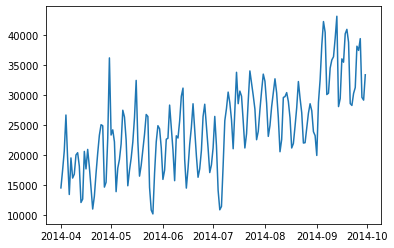

In [28]:
pl.plot( dat.ds, dat.y)

<font color=red> Plot of number of Uberrides on each day from April, 01 to September, 30 for year 2014

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

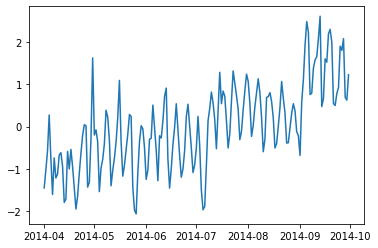

In [29]:
dat['ys'] = (dat['y'] - dat.y.mean())/dat.y.std()
pl.plot( dat.ds, dat.ys)

<font color=red> Plot of number of normalized Uberrides on each day from April, 01 to September, 30 for year 2014. We normalized the data by subtracting the mean and normalizing it with the standard deviation of the number of rides for the 6 months period.

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [0]:
dat.drop(['y'], axis=1, inplace=True)
dat.rename(columns={'ys':'y'}, inplace=True)

In [31]:
model = Prophet(growth='linear') #Define a linear model
model.fit(dat) # Fit the dataframe to the model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
%%time
# Define a future datetime for 30days
future = model.make_future_dataframe(freq='D', periods=30)

# Perform forecast on the future
forecast = model.predict(future)

CPU times: user 1.79 s, sys: 11 ms, total: 1.8 s
Wall time: 1.81 s


In [33]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.671657,0.051910,1.328907
209,2014-10-27,0.950767,0.291916,1.571064
210,2014-10-28,1.528120,0.867550,2.192044
211,2014-10-29,1.885666,1.168468,2.513246
212,2014-10-30,2.204848,1.569639,2.871107


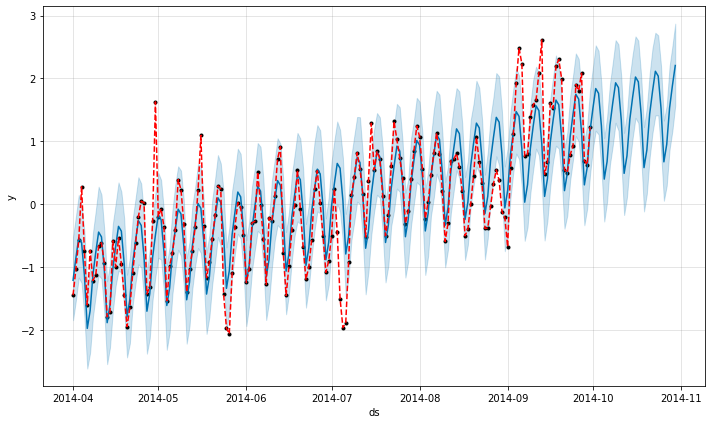

In [35]:
fig1 = model.plot(forecast)
pl.plot(dat.y, 'r--')

<font color=red> Plot of number of normalized Uberrides on each day from April, 01 to September, 30 for year 2014 in red color and the forecast data along with 95% confidence interval in the shaded reagion. The data was obtained using the **Facebook Prophet** model

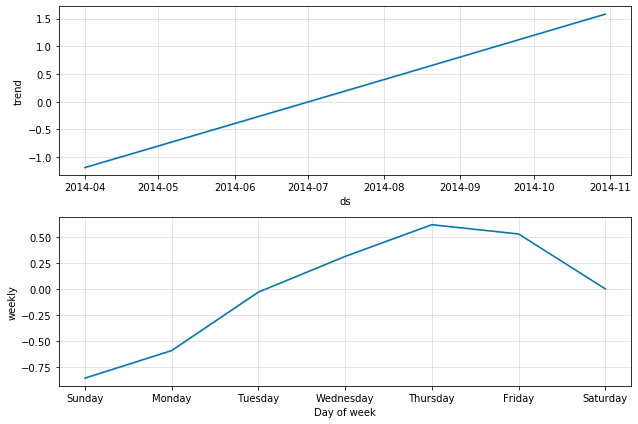

In [36]:
fig2 = model.plot_components(forecast)

<font color=red> The plot shows the components as derived from the Facebook Prophet model. The top figure shows the trend line and the lower figure shows the weekly variation in the trend.

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [0]:
diagnostics.cross_validation?

In [0]:
def rchi2(y, ytrue):

    #chisq = sum((y-ytrue)**2)
    chisq = sum((y-ytrue)**2/len(y))
    return chisq

In [38]:
%%time
cvresult_model = diagnostics.cross_validation(model, initial='92D', period='15D', horizon='30D')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


CPU times: user 8.66 s, sys: 31.1 ms, total: 8.69 s
Wall time: 8.69 s


In [39]:
chisq_val = rchi2(cvresult_model.y, cvresult_model.yhat)
print(chisq_val)

0.4602355257526829


In [40]:
cvresult_model.describe()

,yhat,yhat_lower,yhat_upper,y
count,150.000000,150.000000,150.000000,150.000000
mean,0.323665,-0.280629,0.925946,0.585979
std,0.601327,0.598480,0.606735,0.846319
min,-1.073989,-1.639834,-0.518577,-1.967473
25%,-0.147583,-0.721699,0.450257,0.012149
50%,0.413505,-0.189168,1.013616,0.574224
75%,0.756606,0.158192,1.402987,1.057247
max,1.434275,0.824426,2.015242,2.610584


# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [41]:
!pip install wwo_hist

  Created wheel for wwo-hist: filename=wwo_hist-0.0.4-cp36-none-any.whl size=4216 sha256=9f26a2393415c863a36d48f357725c914d6a5394fa188faef2a8e8bc12d1ab2b
  Stored in directory: /root/.cache/pip/wheels/c5/0e/16/329d9233f3b0b7e5fe81b09c5519a193727999c6ae77577ca9
Successfully built wwo-hist


In [0]:
from wwo_hist import retrieve_hist_data

In [43]:
!ls

sample_data


In [44]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [45]:
!pwd

/content


In [46]:
cd /content/gdrive/My Drive/Studies/Spring_2020/PHYS_667

/content/gdrive/My Drive/Studies/Spring_2020/PHYS_667


In [47]:
!ls

codes  data  figures  MLTSA  New+york,ny.csv  weather.csv


In [48]:
%%time
try :
    weather = pd.read_csv("New+york,ny.csv")
    print(len(weather.index))
except :
    frequency = 24 #fewquency in hours
    start_date = '2014-04-01'
    end_date = '2014-09-30'
    api_key = pd.read_csv("weather.csv", header=None, 
                          index_col=0).loc["wwo"].values[0]
    location_list = ['New+york,ny']
    hist_weather_data = retrieve_hist_data(api_key, location_list, start_date,
                                    end_date, frequency, location_label = False,
                                    export_csv = True)
    weather = pd.read_csv("New+york,ny.csv")
    print(len(weather.index))

213
CPU times: user 6.96 ms, sys: 55 µs, total: 7.01 ms
Wall time: 509 ms


In [49]:
!ls

codes  data  figures  MLTSA  New+york,ny.csv  weather.csv


In [0]:
ny_df = None
ny_df = pd.DataFrame({
    'tempC':(weather.tempC-weather.tempC.mean())/weather.tempC.std(),
    'rainfall':(weather.precipMM-weather.precipMM.mean())/weather.precipMM.std()
                       })
ny_df.set_index(pd.to_datetime(weather.date_time), inplace=True)

In [52]:
ny_df.head()

,tempC,rainfall
date_time,,
2014-04-01,-1.959822,-0.484962
2014-04-02,-1.959822,-0.430609
2014-04-03,-1.766830,-0.484962
2014-04-04,-3.117776,0.737969
2014-04-05,-2.345807,-0.457786


In [0]:
uberweather = dat.join(ny_df, how='inner') #Merge the weather DF to Uberrides

In [55]:
uberweather.keys()

Index(['ds', 'y', 'tempC', 'rainfall'], dtype='object')

In [56]:
uberweather.head()

,ds,y,tempC,rainfall
2014-04-01,2014-04-01,-1.449528,-1.959822,-0.484962
2014-04-02,2014-04-02,-1.034719,-1.959822,-0.430609
2014-04-03,2014-04-03,-0.577551,-1.766830,-0.484962
2014-04-04,2014-04-04,0.274309,-3.117776,0.737969
2014-04-05,2014-04-05,-0.744721,-2.345807,-0.457786


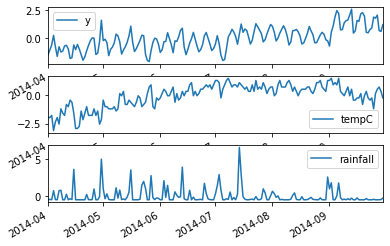

In [57]:
fig, ax = pl.subplots(3)
uberweather.plot(y="y", ax=ax[0])
uberweather.plot(y="tempC", ax=ax[1])
uberweather.plot(y="rainfall", ax=ax[2])

<font color=red> Plot of (from top to bottom) normalized number of daily Uber rides, daily average temperature (in degrees celcius) and rainfall (in mm) for New York city.

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [58]:
%%time
regrm = Prophet(growth='linear')
regrm.add_regressor('tempC')
regrm.add_regressor('rainfall')

CPU times: user 83 µs, sys: 2 µs, total: 85 µs
Wall time: 88.9 µs


In [59]:
uberweather.keys()

Index(['ds', 'y', 'tempC', 'rainfall'], dtype='object')

In [60]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


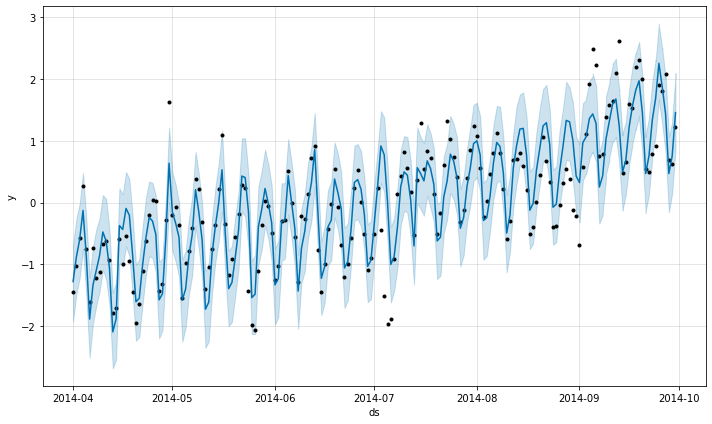

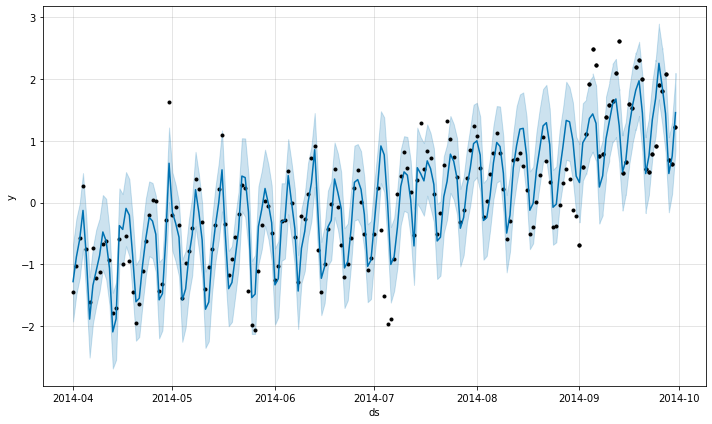

In [61]:
nowcast = regrm.predict(uberweather)
model.plot(nowcast)
regrm.plot(nowcast);

<font color=red> Plot of data along with the forecast from two different models. The top graph shows the forecast for normalized daily rides without taking weather into account (temperature and rainfall) whereas lower plot takes into account the average daily temperature and rainfall.

In [62]:
%%time
cvresult_model2 = diagnostics.cross_validation(regrm, initial='92D', period='15D', horizon='30D')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


CPU times: user 8.72 s, sys: 34.3 ms, total: 8.75 s
Wall time: 8.77 s


In [63]:
chisq_val = rchi2(cvresult_model2.y, cvresult_model.yhat)
print(chisq_val)

0.45801394049598626


# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [64]:
regholm = Prophet()
regholm.add_regressor('tempC')
regholm.add_regressor('rainfall')
regholm.add_country_holidays(country_name='US')
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


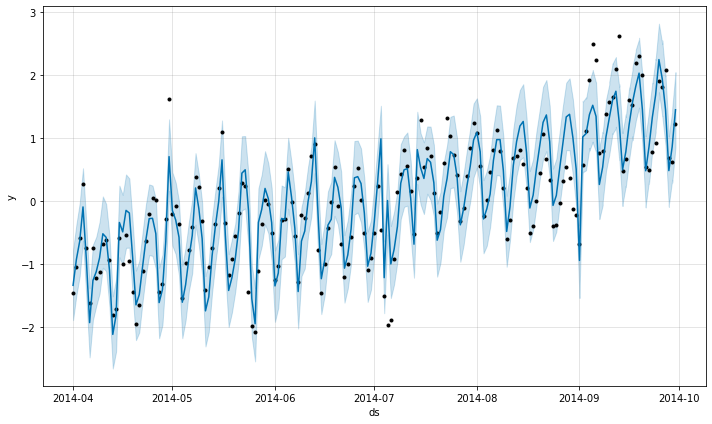

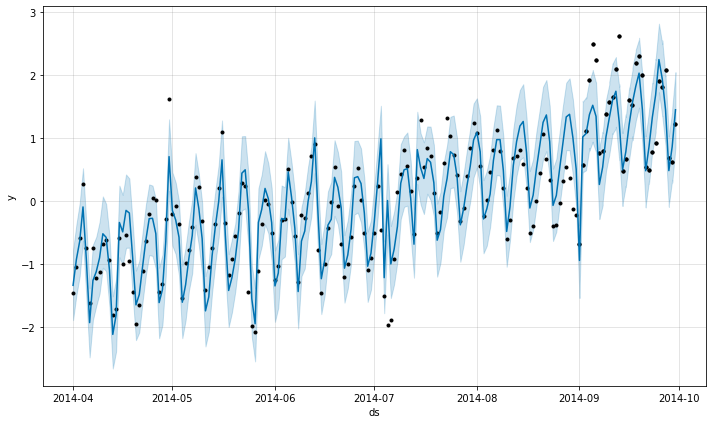

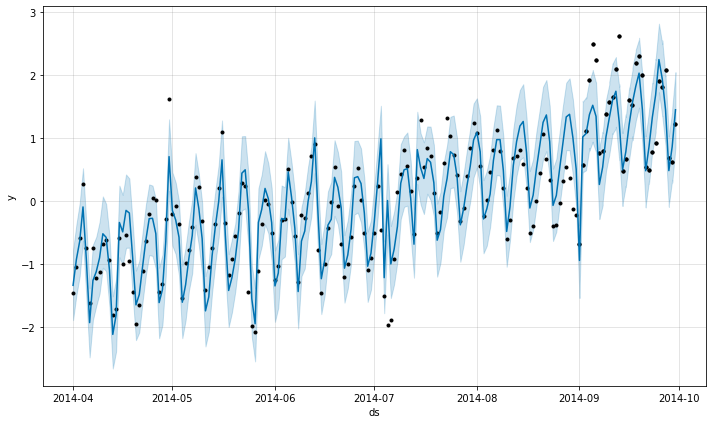

In [66]:
nowcast2 = regholm.predict(uberweather)
model.plot(nowcast2)
regrm.plot(nowcast2)
regholm.plot(nowcast2);

<font color=red> Plot of data along with the forecast from two different models. The graphs (from top to bottom) show the forecast for normalized daily rides without taking weather into account (temperature and rainfall), after taking weather into account and after including the effect of holidays in USA.

In [67]:
%%time
cvresult_model3 = diagnostics.cross_validation(regholm, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_model3.y, cvresult_model3.yhat)
print(chisq_val)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.42080933003509174
CPU times: user 9.32 s, sys: 14.1 ms, total: 9.33 s
Wall time: 9.35 s


# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 15.6 s, sys: 586 ms, total: 16.1 s
Wall time: 1min 18s


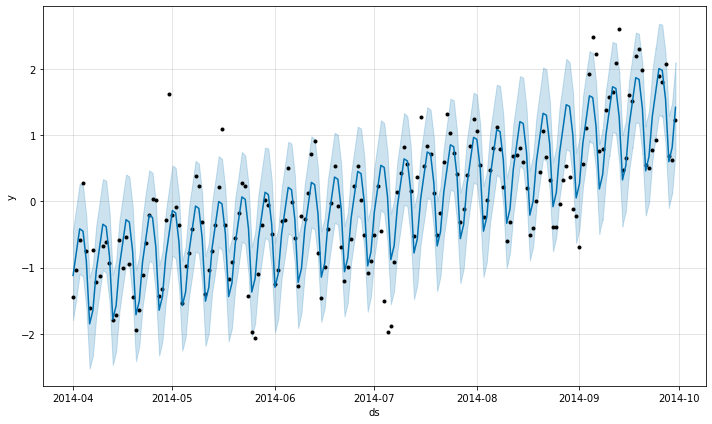

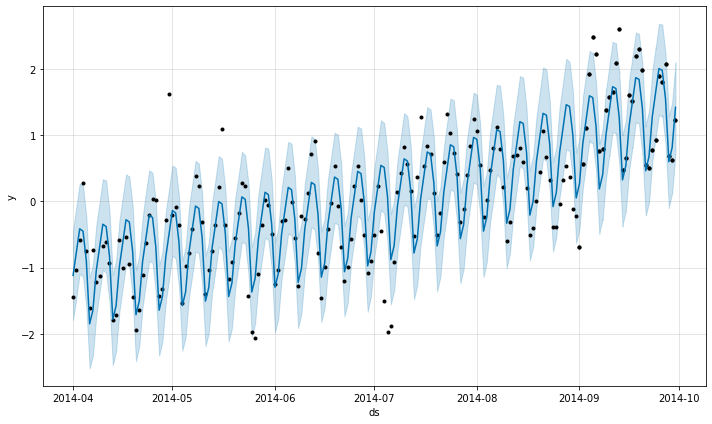

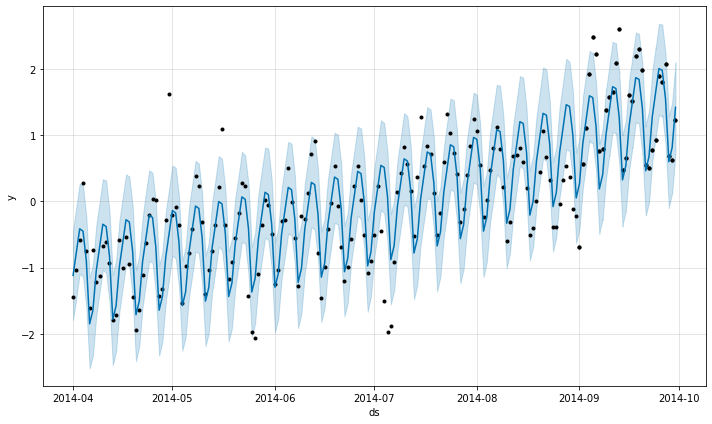

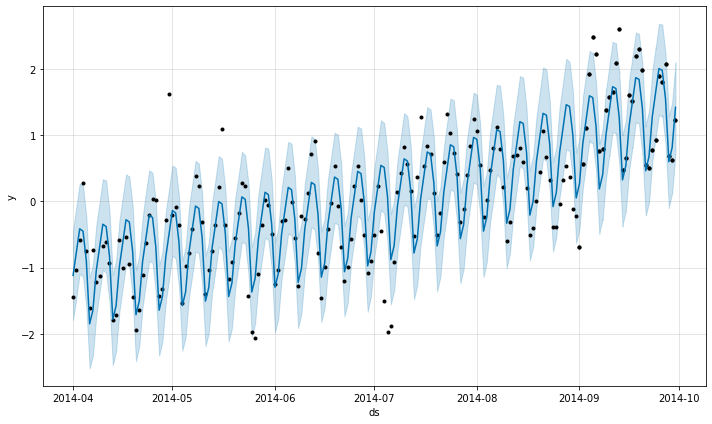

In [68]:
%%time
regmcmc1 = Prophet(mcmc_samples=5000)
regmcmc1.fit(uberweather)

nowcastmcmc1 = regmcmc1.predict(uberweather)
model.plot(nowcastmcmc1)
regrm.plot(nowcastmcmc1)
regholm.plot(nowcastmcmc1)
regmcmc1.plot(nowcastmcmc1);

<font color=red> Plot of data along with the forecast from two different models. The graphs (from top to bottom) show the forecast for normalized daily rides without taking weather into account (temperature and rainfall), after taking weather into account and after including the effect of holidays in USA and the bottom most shows the graph of forecast for the case where forecasting was done using the MCMC optimization in a fully Bayesian model </font>

In [69]:
%%time
cvresult_mcmc1 = diagnostics.cross_validation(regmcmc1, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_mcmc1.y, cvresult_mcmc1.yhat)
print(chisq_val)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.5617103515328322
CPU times: user 1min 16s, sys: 1.26 s, total: 1min 17s
Wall time: 3min 56s


In [70]:
%%time
regmcmc2 = Prophet(mcmc_samples=5000)
regmcmc2.add_regressor('tempC')
regmcmc2.add_regressor('rainfall')

regmcmc2.fit(uberweather)
nowcastmcmc2 = regmcmc2.predict(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 15.7 s, sys: 756 ms, total: 16.4 s
Wall time: 1min 22s


CPU times: user 197 ms, sys: 104 ms, total: 302 ms
Wall time: 180 ms


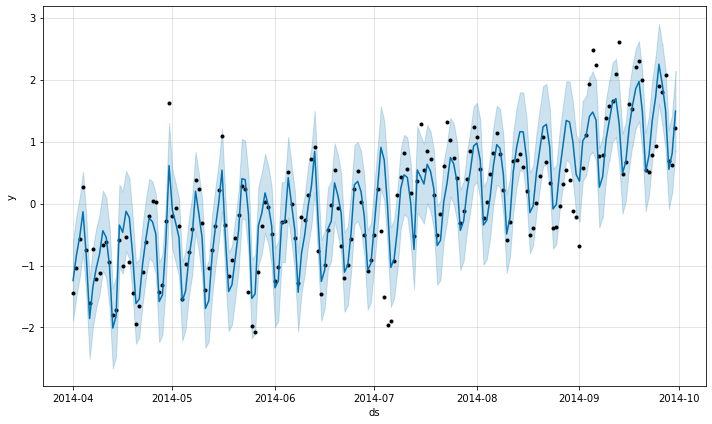

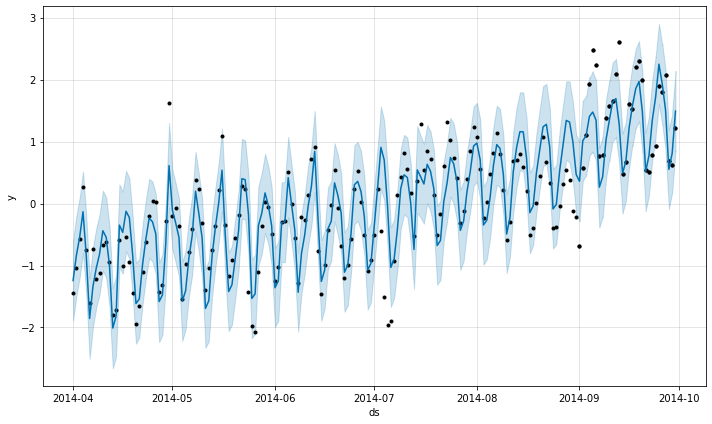

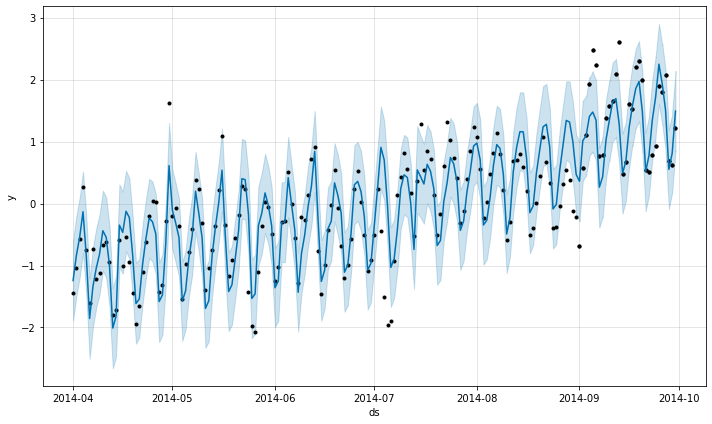

In [74]:
%%time
model.plot(nowcastmcmc2)
regmcmc1.plot(nowcastmcmc2);
regmcmc2.plot(nowcastmcmc2);

<font color=red> Plot of data along with the forecast from two different models. The graphs (from top to bottom) show the forecast for normalized daily rides without taking weather into account (temperature and rainfall), the next three figures show forecast for the case where forecasting was done using the MCMC optimization in a fully Bayesian model without taking any weather or holiday into account followed by just considering weather</font>

In [72]:
%%time
cvresult_mcmc2 = diagnostics.cross_validation(regmcmc2, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_mcmc2.y, cvresult_mcmc2.yhat)
print(chisq_val)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.48857436430456
CPU times: user 1min 15s, sys: 1.49 s, total: 1min 16s
Wall time: 4min 16s


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.49289004835819106
CPU times: user 1min 33s, sys: 3.96 s, total: 1min 37s
Wall time: 8min 3s


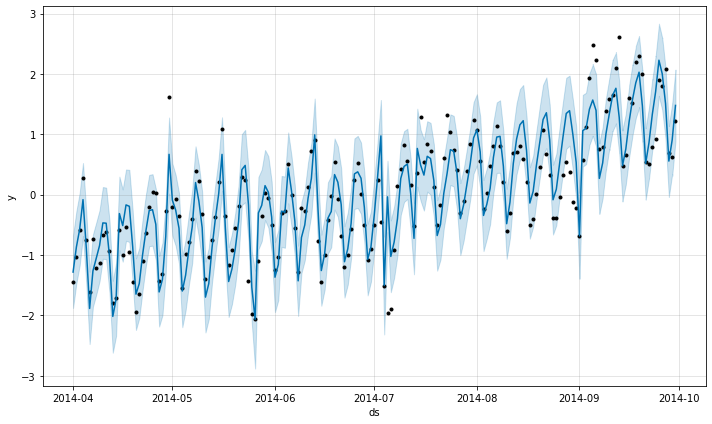

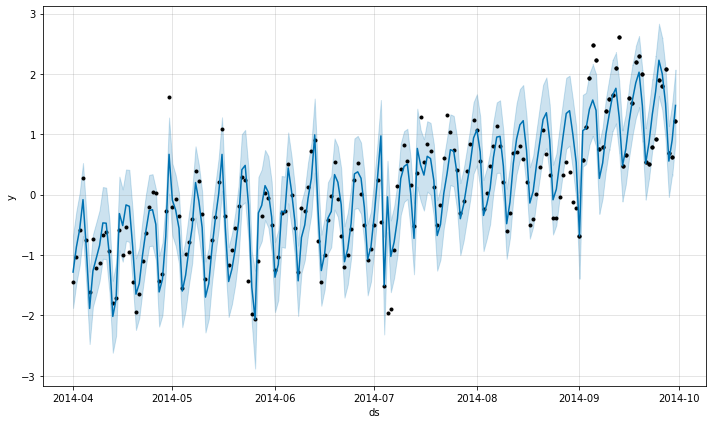

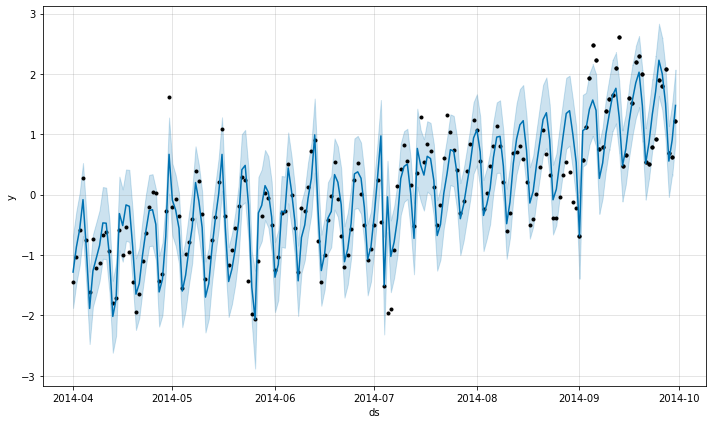

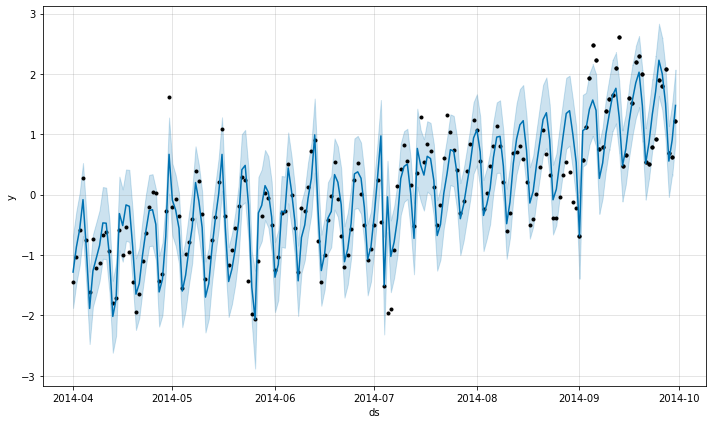

In [73]:
%%time
regmcmc3 = Prophet(mcmc_samples=5000)
regmcmc3.add_regressor('tempC')
regmcmc3.add_regressor('rainfall')
regmcmc3.add_country_holidays(country_name='US')

regmcmc3.fit(uberweather)

nowcastmcmc3 = regmcmc3.predict(uberweather)
model.plot(nowcastmcmc3)
regmcmc1.plot(nowcastmcmc3);
regmcmc2.plot(nowcastmcmc3);
regmcmc3.plot(nowcastmcmc3);

cvresult_mcmc3 = diagnostics.cross_validation(regmcmc3, initial='92D', period='15D', horizon='30D')
chisq_val = rchi2(cvresult_mcmc3.y, cvresult_mcmc3.yhat)
print(chisq_val)

<font color=red> Plot of data along with the forecast from two different models. The graphs (from top to bottom) show the forecast for normalized daily rides without taking weather into account (temperature and rainfall), the next three figures show forecast for the case where forecasting was done using the MCMC optimization in a fully Bayesian model without taking any weather or holiday into account followed by just considering weather and then implementing the method with weather and holidays into account</font>

<font color=red> A summary of $\chi^2$ for various methods as found after the cross validation method.

|method | Added parameters considered | $\chi^2$ |
| ------------- |:-------------:| -----:|
|**Facebook Prophet Model** |
|| Standard | 0.460 |
|| Daily Weather | 0.458 |
|| Daily Weather and US Holidays | 0.421 |
|**MCMC Optimization**|
|| Standard | 0.561 |
|| Daily Weather | 0.489 |
|| Daily Weather and US Holidays | 0.497 |
| || |